In [2]:
# Created January 4, 2021
# Updated January 7, 2021

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
if True:
    mpl.rcParams['lines.linewidth'] = 0.75
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.size'] = 8
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.05
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['xtick.major.pad'] = 2
    mpl.rcParams['xtick.minor.pad'] = 1.5
    mpl.rcParams['ytick.major.pad'] = 2
    mpl.rcParams['ytick.minor.pad'] = 1.5
    mpl.rcParams['figure.facecolor'] = (1,1,1,1) #white
    mpl.rcParams['figure.edgecolor'] = (1,1,1,1) #white
    mpl.rcParams['axes.titlesize'] = 10
    mpl.rcParams['legend.fontsize'] = 6
    mpl.rcParams['axes.labelpad'] = 0

import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

blues = mpl.cm.get_cmap('Blues')
reds = mpl.cm.get_cmap('Reds')

import methods.filter_lineages as fl
import pickle

In [3]:
# bac, bc = 'BtVPI', 'HL'
# norm = mpl.colors.LogNorm( 1, 3e3 )

# with open('muller_lineages.pkl', 'rb') as f:
#     muller_lineage_dict = pickle.load(f)

def plot_lfc_heat_map(ax, lfcs1, lfcs2, binspace, norm=None, cmap=blues, colorbar=True):
    where_finite = (lfcs1.mask + lfcs2.mask == 0)

    density, binx, biny = np.histogram2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace)

    if not norm:
        norm = mpl.colors.LogNorm( 1, np.max(density) )

    ## plot empirical
    ax.hist2d(lfcs1[where_finite], lfcs2[where_finite], bins = binspace, cmap=cmap, norm=norm)


    if colorbar:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

def plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple,
                               norm=mpl.colors.LogNorm(0.1, 3e3),
                               colorbar=False, cmap=mpl.cm.Reds,
                               minfreq=10**-6.5, plot_muller=False):
    m1, m1t1, m1t2 = m1_tuple
    m2, m2t1, m2t2 = m2_tuple

    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()
    lineage_bool = day0_freqs > minfreq

    m1_reads1, m1_reads2 = fl.get_read_arrays(bac, m1, m1t1, m1t2, split_day0=2)
    m2_reads1, m2_reads2 = fl.get_read_arrays(bac, m2, m2t1, m2t2, split_day0=1)
    m1_D1, m1_D2 = m1_reads1.sum(), m1_reads2.sum()
    m2_D1, m2_D2 = m2_reads1.sum(), m2_reads2.sum()
    m1_freqs1, m1_freqs2 = m1_reads1 / m1_D1, m1_reads2 / m1_D2
    m2_freqs1, m2_freqs2 = m2_reads1 / m2_D1, m2_reads2 / m2_D2

    m1_f1, m1_f2 = fl.maxmin_freqs(m1_freqs1, m1_D1, m1_freqs2, m1_D2)
    m2_f1, m2_f2 = fl.maxmin_freqs(m2_freqs1, m2_D1, m2_freqs2, m2_D2)

    m1_lfcs = fl.calc_lfc_array( m1_f1, m1_f2, m1t2-m1t1)
    m2_lfcs = fl.calc_lfc_array( m2_f1, m2_f2, m2t2-m2t1)

    avg_lfcs = np.mean([m1_lfcs, m2_lfcs], axis=0)
    avg_lfcs = np.ma.masked_array(avg_lfcs, mask=(m1_lfcs.mask+m2_lfcs.mask)>0)
    delta_lfcs = np.abs(m1_lfcs - m2_lfcs)
    delta_lfcs = np.ma.masked_array(delta_lfcs, mask=(m1_lfcs.mask+m2_lfcs.mask)>0)

    binspace = [np.linspace(-1.0, 1.0, 21),
                np.linspace(0,1,21)]
    # binspace = [ np.linspace(-np.log(1/epsilon)/dt1 -1/100, np.log(1/epsilon)/dt1 + 1/100, 41),
    #              np.linspace(-np.log(1/epsilon)/dt2 -1/100, np.log(1/epsilon)/dt2 + 1/100, 41)]
    plot_lfc_heat_map(ax, avg_lfcs[lineage_bool], delta_lfcs[lineage_bool],  binspace, norm=norm, colorbar=colorbar, cmap=cmap)

    if plot_muller:
        for diet, marker in [('HF', (3,0,-90)), ('LF', (3,0,0)), ('HLH', (3,0,-45)), ('LHL', (3,0,-45))]:
            muller_lineages = muller_lineage_dict[bac][diet]


            m1_star_lfcs = m1_lfcs[muller_lineages]
            m2_star_lfcs = m2_lfcs[muller_lineages]

            ax.scatter(np.mean([m1_star_lfcs,m2_star_lfcs],axis=0),
            np.abs(m1_star_lfcs-m2_star_lfcs), color=DIET_COLORS[diet], marker=marker, s=25, zorder=20)

# diet_colors = {'HF':'red', 'LF':'blue', 'HLH':'orange', 'LHL':'purple'}
#
# def make_fit_barcode_gene_points(bac, bc, sorted_indices, mice, t0, t1):
#     """ Assuming single mouse """
#     barcode_positions = barcodes[bac][bc]
#     position_to_index_map = {pos: i for i, pos in enumerate(barcode_positions)}
#
#     sorted_positions = barcode_positions[sorted_indices]
#
#     coarse_grained_lfc = []
#
#     mice_freqs_t0 = freq_dict[bac][bc][ [MX[(mouse, t0)] for mouse in mice] ]
#     mice_freqs_t1 = freq_dict[bac][bc][ [MX[(mouse, t1)] for mouse in mice] ]
#
#     for i in range(len(sorted_indices)):
#         try:
#             gene = barcode_gene_dict[bac][sorted_positions[i]][0]
#             gene_bc_positions = set(gene_barcode_dict[bac][gene][1])
#             gene_bc_indices = [ position_to_index_map[pos] for pos in gene_bc_positions ]
#         except:
#             coarse_grained_lfc.append(0)
#             continue
#
#         cg_gene_t0 = mice_freqs_t0[:, gene_bc_indices].sum(axis=1) - mice_freqs_t0[:, sorted_indices[i]]
#         cg_gene_t1 = mice_freqs_t1[:, gene_bc_indices].sum(axis=1) - mice_freqs_t1[:, sorted_indices[i]]
#
#         coarse_grained_lfc.append( np.log( cg_gene_t1 / cg_gene_t0 ) / (t1-t0) )
#     return np.array(coarse_grained_lfc) # dimension = len(sorted_indices)
#
# def plot_tradeoff_barcode_fold_changes(ax, bac, bc, bc_index, day0_lfcs, vitro_lfc_map, cutoff=1e-6, plot_gene_complement=False):
#     ## sort by diet in time window
#     ax.axhline(0, color='black', linestyle='dashed', alpha=0.5)
#     s = 6
#
#     diet_x1x2 = {'HF': (0, 2), 'LF': (1, 3), 'HLH': (0, 3), 'LHL':(1, 2),
#                  'Arabinose':4, 'Glucose':5, 'TYG':6, 'WAX':7, 'Xylose':8}
#     # diet_x1x2 = {'HF': (0, 1), 'LF': (2, 3), 'HLH': (0, 3), 'LHL':(2, 1),
#     #              'Arabinose':4, 'Glucose':5, 'TYG':6, 'WAX':7, 'Xylose':8}
#     diet_day_color_map = {('HF', 4): 'red', ('HF', 10): 'red', ('HF', 16): 'red',
#                     ('LF', 4): 'blue', ('LF', 10): 'blue', ('LF', 16): 'blue',
#                     ('LHL', 4): 'blue', ('LHL', 10): 'red', ('LHL', 16): 'blue',
#                     ('HLH', 4): 'red', ('HLH', 10): 'blue', ('HLH', 16): 'red'}
#     for diet in ['HF', 'LF', 'HLH', 'LHL']:
#         mice = DIET_MICE_MAP[diet]
#
#         day0_freqs = freq_dict[bac][bc][-1]
#         day4_freqs = freq_dict[bac][bc][[MX[(m, 4)] for m in mice]]
#         day10_freqs = freq_dict[bac][bc][[MX[(m, 10)] for m in mice]]
#         day16_freqs = freq_dict[bac][bc][[MX[(m, 16)] for m in mice]]
#
#         lfcs_04 = np.log( (day4_freqs[:, bc_index] + cutoff) / day0_freqs[bc_index])/4
#         lfcs_410 = np.log((day10_freqs[:, bc_index] + cutoff) / (day4_freqs[:, bc_index] + cutoff) )/6
#         lfcs_1016 = np.log((day16_freqs[:, bc_index] + cutoff) / day10_freqs[:, bc_index] + cutoff)/6
#
#         # rnd_indices = rnd.choice( np.arange(day0_freqs.shape[-1])[ day0_freqs > 10**-4 ], size=50, replace=False )
#         # lfcs_04_rnd_median = np.median( (day4_freqs[:, rnd_indices] + cutoff) / (day0_freqs[rnd_indices] + cutoff), axis = 1 ) / 6
#         # lfcs_410_rnd_median = np.median( (day10_freqs[:, rnd_indices] + cutoff) / (day4_freqs[:, rnd_indices] + cutoff), axis = 1 ) / 6
#
#         lfcs_04_rnd_median, lfcs_410_rnd_median = 0, 0
#
#         x1, x2 = diet_x1x2[diet]
#
#         ax.scatter( x1 + rnd.normal(0, 0.12, len(mice)), np.exp(4*(lfcs_04 - lfcs_04_rnd_median)), color=diet_day_color_map[(diet, 4)], facecolors='none', label=diet, s=s)
#         ax.scatter( x2 + rnd.normal(0, 0.12, len(mice)), np.exp(6*(lfcs_410 - lfcs_410_rnd_median)), color=diet_day_color_map[(diet, 10)], facecolors='none', label='_', s=s)
#
#         if plot_gene_complement == True:
#             gene_lfcs_04 = np.ravel( make_fit_barcode_gene_points(bac, bc, [bc_index], mice, 0, 4) )
#             gene_lfcs_410 = np.ravel( make_fit_barcode_gene_points(bac, bc, [bc_index], mice, 4, 10) )
#             try:
#                 ax.scatter( x1 + rnd.normal(0, 0.12, len(mice)), gene_lfcs_04 - lfcs_04_rnd_median, color=diet_colors[diet], marker='x')
#                 ax.scatter( x2 + rnd.normal(0, 0.12, len(mice)), gene_lfcs_410 - lfcs_410_rnd_median, color=diet_colors[diet], marker='x')
#             except:
#                 continue
#             ax.scatter( 2 + rnd.normal(0, 0.12, len(mice)), lfcs_410_rnd_median, color='black')
#
#     ax.scatter( 4 + rnd.normal(0, 0.12, 2), np.exp(day0_lfcs[:, bc_index]), color='black', facecolors='none', label='day 0', s=s)
#
#     x = np.arange(5, 10)
#     for i, (medium, vitro_lfcs) in zip(x, vitro_lfc_map.items()):
#         ax.scatter( i + rnd.normal(0, 0.12, 2), np.exp(vitro_lfcs[:, bc_index]), color='black', facecolors='none', label='$\it{in~vitro}$', s=s)
#
#     # ax.text(0.3, 0.9, 'bc {} = {}'.format(bc_index, read_dict[bac][bc][-1][bc_index]), transform=ax.transAxes)
#     # ax.axvspan(ax.get_xlim()[0], 1.5, color='blue', alpha=0.05)
#     # ax.axvspan(1.5, ax.get_xlim()[1], color='red', alpha=0.05)

with open('../figure1_muller_and_transition/10biggest_indices_v2.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)




1 0
1 2


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt


3 0
3 2


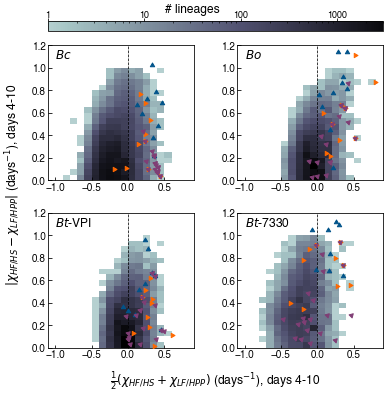

In [32]:
HF_mice, LF_mice = [DIET_MICE_MAP['HF'], DIET_MICE_MAP['LF']]
HLH_mice, LHL_mice = [DIET_MICE_MAP['HLH'], DIET_MICE_MAP['LHL']]
diet_names = {'HF':'HF/HS', 'LF':'LF/HPP'}

def savefig(fig, i):
    fig.savefig( f'{plot_dir}/presentation_figures/fig3_tradeoffs_v{i}.png' )
    return i+1
version = 1
### FIGURE 3 ###

fig = plt.figure(figsize=(6, 6))

outer = mpl.gridspec.GridSpec(nrows=4, ncols=3,
                              height_ratios=(0.07, 1, 0.03, 1),
                              width_ratios=(1,0.03, 1))
outer_ax = fig.add_subplot(outer[:, :])
outer_ax.set_ylabel(r'$|\chi_{HF/HS}-\chi_{LF/HPP}|$ (days$^{-1}$), days 4-10', fontsize=12, labelpad=15)
outer_ax.set_xlabel(r'$\frac{1}{2}(\chi_{HF/HS}+\chi_{LF/HPP})$ (days$^{-1}$), days 4-10', fontsize=12, labelpad=15)
ax_methods.turn_off_ax(outer_ax)

norm=mpl.colors.LogNorm(0.1, 5e3)

m1, m2 = [6, 7, 8, 9, 10], [16, 18, 19]
for b, bac in enumerate(BACTERIA):
    print(1+2*(b//2), 2*(b%2))
    t0, t1 = 4, 10
    diet1, diet2 = mouse2diet[m1[0]], mouse2diet[m2[0]]
    xlabel = f'{diet1} {t0}-{t1}'
    ylabel = f'{diet2} {t0}-{t1}'

    m1_tuple = (m1, t0, t1)
    m2_tuple = (m2, t0, t1)

    ax = fig.add_subplot(outer[1+2*(b//2), 2*(b%2)])
    plot_lfc_hmap_correlations(ax, bac, m1_tuple, m2_tuple, colorbar=False,
                               cmap=mpl.cm.bone_r, norm=norm, plot_muller=True)
    ax.text(0.05, 0.9, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=12)
    # ax.text(0.1, 0.9, BAC_FORMAL_NAMES[bac], transform=ax.transAxes)

    # if bac == 'BWH2': min = -1.0
    # elif bac == 'BtVPI': min = -0.6
    # elif bac == 'Bovatus': min = -0.6
    # elif bac == 'Bt7330': min = -1.0
    # ax.set_xlim(min, 0.8)
    # ax.set_ylim(0, 1.2)

    ax.axvline(0, color='black', linestyle='dashed', zorder=5)
    ax.axhline(0, color='black', linestyle='dashed', zorder=5)
    ax.set_xlim(-1.1, 0.9)
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=10)

if 'colorbar':
    colorbar_ax = fig.add_subplot(outer[0, :])
    _ = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=mpl.cm.bone_r,
        ticklocation='top', norm=norm, orientation='horizontal')
    colorbar_ax.tick_params(axis='both', direction='out', labelsize=9, pad=-1)
    # colorbar_ax.set_title('# lineages', fontsize=10)
    # colorbar_ax.set_ylabel('# lineages', fontsize=10, labelpad=8, rotation=-90)
    colorbar_ax.set_xlim(1, 3000)
    colorbar_ax.set_xticks([1, 10, 100, 1000])
    colorbar_ax.set_xticklabels(['1', '10', '100', '1000'])
    colorbar_ax.text(0.35, 2, '# lineages', transform=colorbar_ax.transAxes, fontsize=12)

fig.savefig(f'{biorxiv}/SI_410_avg_vs_delta_fitnesses.pdf')